In [4]:
# Regular packages
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore") # might not be the best idea

In [5]:
# pyspark packages 
from pyspark.sql.functions import col, concat, collect_list,struct
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, array, array_distinct, array_min,array_max,array_union, explode
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark import SparkContext
from pyspark.sql import Row

## Analysis of RDD 

In [3]:
def file_to_rdd(file):
    """
    This function takes a file name and converts it into an RDD.
    
    Arguments:
    file (str): file name
    
    Returns:
    An RDD containing all information extracted from the file.
    """

    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).cache()

        rdd = adj_cache.rdd.map(tuple)
        return rdd
    elif file[-3:] == "txt" : 
        rdd_web = sc.textFile(file) \
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

        return rdd_web

In [6]:
sc = SparkContext()

In [7]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [6]:
#First try with the example of the research paper 

from pyspark import SparkContext

time1 = time.time()

graph = sc.parallelize([(0, 1), (1, 2), (1, 3), (3, 4), (5, 6), (6, 7)])
counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
  
    graph.collect()
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  4
counter:  9
counter:  4
counter:  0
It took 7.684 seconds


In [16]:
#Let's try with the Google Graph 

web_google = sc.textFile("web-Google 2.txt")\
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

graph = web_google

time1 = time.time()

counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 16.0 failed 1 times, most recent failure: Lost task 2.0 in stage 16.0 (TID 82) (hippolytes-macbook-pro.home executor driver): java.io.IOException: Cannot run program "python3.6": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:209)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:247)
	at java.lang.ProcessImpl.start(ProcessImpl.java:134)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 27 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Cannot run program "python3.6": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:209)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:115)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:247)
	at java.lang.ProcessImpl.start(ProcessImpl.java:134)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 27 more


In [ ]:
# Comparison according to graph size 

values = [len(web_google.collect())//(10-i) for i in range(1, 10)]

time_ = []

for i in range(len(values)):
    graph = sc.parallelize(web_google.collect()[1:values[i]])
    
    time1 = time.time()
    
    counter_new_pair = sc.accumulator(1)
    
    while counter_new_pair.value > 0:
        
        counter_new_pair = sc.accumulator(0)

        #CCF-Iterate
        mapping_1 = graph.map(lambda node : (node[0], node[1]))
        mapping_2 = graph.map(lambda node : (node[1], node[0]))
        fusion = mapping_1.union(mapping_2)
        fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
        joined = fusion.flatMap(lambda node: reducer(node))
        # CCF-Dedup
        graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
        graph = graph.map(lambda x: (x[0][0], x[0][1]))
        graph.collect()
    
    time2 = time.time()
    
    time_.append((i, time2-time1))

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))]);

## Try part, Dataframe

In [18]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("val","key").cache()

In [19]:
df.show()

+------+------+
|   val|   key|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



In [ ]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

8275872


In [39]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

liste = []
for i in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("val","key").cache()
    begin = time.time()
    counter = 1
    iteration = 0
    while counter!=0:
        iteration +=1
        df1 = ccf_iterate_map_df(df)
        df1.cache()
        df.unpersist()
        df, df_counter = ccf_iterate_reduce_df(df1)
        df.cache()
        df1.unpersist()
        df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
        counter = df_counter.select(sum("counter_col")).collect()[0][0]
        print(counter)
    
    end = time.time()
    print((i, end-begin))
    liste.append((i, end-begin))

645720
188263
249888
326246
252536
73441
518
0
('web-Google_500000.csv', 476.46466517448425)
1379336
411275
466760
634325
483907
133761
1344
0
('web-Google_1000000.csv', 543.9730443954468)
2158798
651571
663595
916646
680213
154277
1966
0
('web-Google_1500000.csv', 571.6710729598999)
2965172
912104
846662
1189233
876542
174605
2038
0
('web-Google_2000000.csv', 583.3043549060822)
3789920
1184366
1023125
1451456
1057318
205858
2436
0
('web-Google_2500000.csv', 596.1450490951538)
4630528
1479228
1199555
1712234
1248788
214513
3162
0
('web-Google_3000000.csv', 632.7033257484436)
5483928
1785818
1373705
1981569
1446347
232332
4126
10
0
('web-Google_3500000.csv', 830.4311218261719)
6343536
2102129
1548923
2262060
1654681
257297
5834
22
0
('web-Google_4000000.csv', 929.0334510803223)
8275872
2772256
1919694
2879945
2146951


Py4JJavaError: An error occurred while calling o5281.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 43 in stage 967.0 failed 1 times, most recent failure: Lost task 43.0 in stage 967.0 (TID 205085) (hippolytes-macbook-pro.home executor driver): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:870)
	at org.apache.spark.unsafe.map.BytesToBytesMap.reset(BytesToBytesMap.java:974)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.<init>(UnsafeKVExternalSorter.java:173)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.destructAndCreateExternalSorter(UnsafeFixedWidthAggregationMap.java:248)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.GeneratedMethodAccessor171.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:870)
	at org.apache.spark.unsafe.map.BytesToBytesMap.reset(BytesToBytesMap.java:974)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.<init>(UnsafeKVExternalSorter.java:173)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.destructAndCreateExternalSorter(UnsafeFixedWidthAggregationMap.java:248)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [10]:
df = sc.textFile("web-Google 2.txt").collect()

In [11]:
df = sc.parallelize(df)

In [12]:
df = df.map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1])).toDF()

In [13]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

df = sc.textFile("web-Google 2.txt").collect()
df = sc.parallelize(df)
df = df.map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1])).toDF()

def ccf_iterate_map_df(df):
    newRow = df.select("_1", "_2")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("_2","_1").partitionBy("_2")
    df_min = df1.withColumn("min", min("_1").over(window))

    new_column_1 = expr( """IF(min > _2, Null, IF(min = _1, _2, _1))""")
    new_column_2 = expr("""IF(min > _2, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("_2"), col("new_val").alias("_1")) \
    .sort("_1", "_2") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter_new_pair = sc.accumulator(1)
iteration = 0
while counter_new_pair!=0:
    counter_new_pair = sc.accumulator(0)
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > _2, 0, IF(min = _1, 0, 1))"""))
    counter_new_pair = sc.accumulator(df_counter.select(sum("counter_col")).collect()[0][0])
    if counter_new_pair==0:
        end = time.time()
        print(end-begin)
        break
    print(counter_new_pair)

8276304
2765183
1913801
2880537
2143683
296831
8504
0
0
0
0


Py4JJavaError: An error occurred while calling o1154.unpersist.
: java.lang.OutOfMemoryError: GC overhead limit exceeded


In [26]:
print(end-begin)

861.835107088089


In [50]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("_1", "_2")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("_2","_1").partitionBy("_2")
    df_min = df1.withColumn("min", min("_2").over(window))

    new_column_1 = expr( """IF(min > _2, Null, IF(min = _1, _2, _1))""")
    new_column_2 = expr("""IF(min > _2, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("_2"), col("new_val").alias("_1")) \
    .sort("_1", "_2") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`key`' given input columns: [_1, _2, min]; line 1 pos 9;
'Project [_1#220960, _2#220961, min#221000, 'IF((min#221000 > 'key), 0, 'IF((min#221000 = 'val), 0, 1)) AS counter_col#221074]
+- Project [_1#220960, _2#220961, min#221000]
   +- Project [_1#220960, _2#220961, min#221000, min#221000]
      +- Window [min(_2#220961) windowspecdefinition(_2#220961, _2#220961 ASC NULLS FIRST, _1#220960 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS min#221000], [_2#220961], [_2#220961 ASC NULLS FIRST, _1#220960 ASC NULLS FIRST]
         +- Project [_1#220960, _2#220961]
            +- Union false, false
               :- LogicalRDD [_1#220960, _2#220961], false
               +- Project [_1#220960 AS _1#220975, _2#220961 AS _2#220976]
                  +- Project [_1#220960, _2#220961]
                     +- LogicalRDD [_1#220960, _2#220961], false


In [ ]:
reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))# getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    df_1 = df_0.groupBy(col("To")).agg(f.array_distinct(collect_list(col("From"))).alias('From'))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    df_2 = df_1.withColumn('From', array_union(df_1.From, array(df_1.To))).withColumn('To', array_min("From"))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()

In [27]:
df.show()

+------+------+
|    To|  From|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



## Analysis of Dataframes

In [35]:
#First, let's define our function to import and analyze Dataframes

def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = 0 
    while df.count()!= df.select('To').distinct().count() :
        counter +=1 
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [37]:
Analyze("web-Google_total.csv")

AttributeError: 'str' object has no attribute 'select'

In [28]:
df_test1 = pd.read_csv("web-Google 2.txt", sep="\t").head(5000000000000000)

In [29]:
df_test1.to_csv("web-Google_test.csv", header=False, index=False)

In [25]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_1000000.csv"]

time_df = []

for file in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).toDF("To","From").cache()
    
    time_df.append(Analyze(df)[0])
    


NameError: name 'Analyze' is not defined

In [15]:
time_df = [742.6663370132446,
 1173.5141010284424,
 1178.273682832718,
 1244.8001997470856,
 2275.856563806534,
 1476.6470799446106,
 1604.9051089286804,
 1770.9568598270416,
 1165.5193858146667]

## RDD vs Dataframe

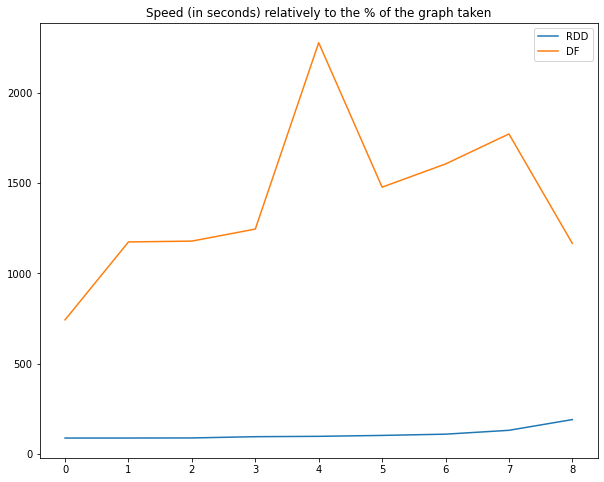

In [22]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))], label="RDD")
plt.plot([time_df[i] for i in range(len(time_df))], label="DF")
plt.legend()
plt.show();

In [46]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google 2.txt.csv").toDF("To","From").cache()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:50245)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:50245)

In [33]:
df.count()

499999

In [51]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

computation = pd.DataFrame(columns=names)

time1 = time.time()

computation.loc["Number of elements"] = [spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache().count() + 1 for i in names]

computation.loc["Number of connected components"] = [Analyze(spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache())[2] for i in names]

computation.loc["Computation time"] = [Analyze(spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache())[3] for i in names]

time2 = time.time()

print("It took {:.2f} seconds for this operation".format(time2-time1))

KeyboardInterrupt: 

In [64]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`val`' given input columns: [From, To];
'Project [To#175938, From#175939, min('val) windowspecdefinition('key, 'key ASC NULLS FIRST, 'val ASC NULLS FIRST, unspecifiedframe$()) AS min#175978]
+- Union false, false
   :- Project [cast(_1#175934 as int) AS To#175938, cast(_2#175935 as int) AS From#175939]
   :  +- LogicalRDD [_1#175934, _2#175935], false
   +- Project [To#175938 AS To#175953, From#175939 AS From#175954]
      +- Project [To#175938, From#175939]
         +- Project [cast(_1#175934 as int) AS To#175938, cast(_2#175935 as int) AS From#175939]
            +- LogicalRDD [_1#175934, _2#175935], false


In [39]:
graph = sc.parallelize(web_google.collect()[1:len(web_google.collect())])
graph = graph.toDF()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:50245)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:50245)

In [34]:
graph.show()

AttributeError: can't set attribute

In [25]:
def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = sc.accumulator(1)
    while df.count()!= df.select('To').distinct().count() :
        counter_new_pair.add(1)
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [27]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`key`' given input columns: [From, To, min]; line 1 pos 9;
'Project [To#521, From#522, min#663, 'IF((min#663 > 'key), null, 'IF((min#663 = 'val), 'key, 'val)) AS new_key#667]
+- Project [To#521, From#522, min#663]
   +- Project [To#521, From#522, min#663, min#663]
      +- Window [min(From#522) windowspecdefinition(To#521, To#521 ASC NULLS FIRST, From#522 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS min#663], [To#521], [To#521 ASC NULLS FIRST, From#522 ASC NULLS FIRST]
         +- Project [To#521, From#522]
            +- Union false, false
               :- Project [0#517 AS To#521, 824020#518 AS From#522]
               :  +- Relation[0#517,824020#518] csv
               +- Project [From#522 AS From#578, To#521 AS To#579]
                  +- Project [From#522, To#521]
                     +- Project [0#517 AS To#521, 824020#518 AS From#522]
                        +- Relation[0#517,824020#518] csv


In [1]:
import time

import pyspark
import pandas as pd
from pyspark.sql import functions as f
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


class SparkDataManager:

    def __init__(self, spark_context, initial_data_path, sep='\\s+', row_limit=None, skip_rows=None):
        if initial_data_path is not None:
            self.sql_context = pyspark.SQLContext(spark_context)
            self.initial_data = self.sql_context.createDataFrame(
                pd.read_csv(
                    initial_data_path,
                    sep=sep,
                    nrows=row_limit,
                    skiprows=skip_rows
                ),
                ['f', 't']
            )
            self.old_data = self.sql_context.createDataFrame(pd.DataFrame([[0, 1]], columns=['f', 't']))
            self.data = self.initial_data
            self.final_output = None
        else:
            raise ValueError("File path shouldn't be None.")

    def get_row_diff_and_update(self, new_data):
        diff = np.abs(self.old_data.count() - new_data.count())
        self.old_data = new_data
        return diff

    def show_data(self, full=False):
        if full:
            self.data.show(self.data.count(), False)
        else:
            self.data.show()

    def save_input(self, file_name):
        self.initial_data.toPandas().to_csv(f'out/spark_out/{file_name}', index=False)

    def save_output(self, file_name=None):
        if file_name is None:
            file_name = 'output.csv'
        if self.final_output:
            self.final_output.toPandas().to_csv(f'./out/spark_out/{file_name}', index=False)

    def load_output(self):
        self.final_output = self.sql_context.createDataFrame(pd.read_csv('./out/spark_out/output.csv'))


class SparkRunner:

    def __init__(self, spark_context, data_path, sep='\\s+', row_limit=None, skip_rows=None):
        self.data_path = data_path
        if data_path is not None:
            self.spark_context = spark_context
            self.sdm = SparkDataManager(
                spark_context=spark_context,
                initial_data_path=data_path,
                sep=sep,
                row_limit=row_limit,
                skip_rows=skip_rows
            )
            self.counter = 1
            self.timer = 0.
        else:
            raise ValueError("File path shouldn't be None.")

    def map(self, data=None):
        """
        For every edge A -> B, emits A -> B and B -> A
        :param data: the data to use for the map. self.data is used by default.
        I don't know if the parameter is useful, maybe for testing purposes
        :return: The mapped data, flattened to be pretty and reconverted to DF to keep the same structure.
        """
        if data is None:
            data = self.sdm.data
        # By doing a flatMap, we manage to emit both (from, to) and (to, from)
        # The output of the map function here is then just the edged duplicated in both ways.
        return data.rdd.flatMap(lambda tup: [(tup[0], tup[1]), (tup[1], tup[0])]).toDF(['f', 't'])

    def reduce(self, data=None, verbose=False):
        """
        # TODO Should this be broken down into functions ?
        This is a bit more than just a reduce.
        Steps performed in this function :
            - Calls the MAP.
            - Computes, for each 'from' node, the minimum 'to' node.
            - Joins the grouped data with the map output.
            - Computes the largest value between 'from' and 'min_t'
            - Filters the edges A -> B with A > B
            - Drops the duplicates.
            - Emits the corresponding edge.
            - Re-aggregates the data to find the minimum 'to' for each 'from'
            - Emits the result.
        :param data: The input data, by default, the output of self.map will be considered.
        :param verbose: Should the intermediate steps be displayed.
        :return: The output of the reduce steps.
        """
        if verbose:
            print('--- INPUT DATA ---')
            self.sdm.show_data()
        data = self.map(data)
        grouped_data = data.groupBy('f') \
            .agg(f.min('t').alias('min_t'))
        first_map_reduce_output = data.join(
            grouped_data,
            'f',
            'inner'
        )
        if verbose:
            print('--- MAP OUTPUT ---')
            first_map_reduce_output.show(first_map_reduce_output.count(), False)
        # TODO See if counter has to be used this way.
        self.counter = self.sdm.get_row_diff_and_update(first_map_reduce_output)

        reduce_out = grouped_data\
            .selectExpr('f as f', 'min_t as t').\
            union(
                first_map_reduce_output.filter('f > min_t').selectExpr('t as f', 'min_t as t')
            )\
            .sort(['f', 't']) \
            .dropDuplicates(['f', 't'])\
            .filter('f > t')

        self.sdm.data = reduce_out

        if verbose:
            print('--- REDUCE OUTPUT ---')
            # reduce_out.show(reduce_out.count(), False)
            self.sdm.show_data()
            print(f'Value of the counter : {self.counter}')
        return reduce_out

    def run(self, data=None, verbose=False):
        """
        Runs the map-reduce algorithm until convergence
        :param data: The data to use. If not provided, the file provided when creating the instance will be used.
        :param verbose: Should the intermediate steps be displayed.
        :return: The output of the last map-reduce algorithm, the connected components of the graph.
        """
        reduce_out = None
        start_time = time.time()
        while self.counter > 0:
            reduce_out = self.reduce(data, verbose=verbose)
        self.sdm.final_output = reduce_out
        self.timer = time.time() - start_time
        return reduce_out

    def plot_graph(self):
        # Color palette used for graph
        color_palette = ['red', 'green', 'blue', 'orange', 'purple', 'pink']
        # Convert data to pandas for convenience.
        pd_initial_data = self.sdm.initial_data.toPandas()
        pd_output_data = self.sdm.final_output.toPandas()
        # Getting nodes list
        from_nodes = pd_initial_data.loc[:, 'f'].unique()
        to_nodes = pd_initial_data.loc[:, 't'].unique()
        all_nodes = list(set(list(from_nodes) + list(to_nodes)))
        # Getting cluster for coloring
        distinct_clusters = list(pd_output_data.loc[:, 't'].unique())
        # Create a dictionary with structure {cluster : color}
        colors = {}
        palette_index = 0
        for cluster in distinct_clusters:
            colors[cluster] = color_palette[palette_index]
            # Using modulo to have infinite color list.
            palette_index = (palette_index + 1) % len(color_palette)
        # Instantiate graph
        graph = nx.Graph()
        color_set = []
        for node in all_nodes:
            # Adding the node to the graph
            graph.add_node(node)
            # Adding the color
            if node in distinct_clusters:
                # If the node is a cluster than assign it's color
                color_set.append(colors[node])
            else:
                # Else find the color of the cluster associated with the node.
                row = pd_output_data[pd_output_data['f'] == node]
                # This if is in case we don't find a color for the node.
                if row.shape[0] > 0:
                    cluster = row.values[0][1]
                    color_set.append(colors[cluster])
                else:
                    color_set.append('grey')

        # Append the edges.
        for index, edge in pd_initial_data.iterrows():
            graph.add_edge(edge[0], edge[1])

        nx.draw(graph, node_color=color_set, with_labels=True)
        plt.show()

In [8]:

#sc = pyspark.SparkContext()

run_list = []

r2 = SparkRunner(sc, 'web-Google 2.txt', row_limit=10000000000000000, skip_rows=4)
r2.run()
run_list.append(r2.timer)
print(r2.timer)

659.0312879085541


In [11]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="python3.6"
import pyspark
#sc = pyspark.SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession(sc)
from pyspark.sql import functions as F
import itertools

def min_fm(x):
    return [(a,x[0]) for a in x[1]]+[(x[0],a) for a in x[1]]

data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("node","neighbor").cache()
data = data.groupby('node').agg(F.collect_list('neighbor'))
print("1", data.show())
i = 0
checker = []

begin = time.time()

while True:
    data = data.rdd.map(tuple)
    print("2", data.collect())
    data = data.flatMap(lambda x:min_fm(x)).toDF(['node','neighbor'])
    print("3", data)
    data = data.groupby('node').agg(F.collect_set('neighbor'))
    print("4", data)
    data = data.rdd.map(tuple)
    print("5", data)
    data = data.map(lambda x: (min([x[0]]+x[1]),list(set(x[1])))).toDF(['node','neighbor'])
    print("6", data)
    data = data.groupby('node').agg(F.collect_list('neighbor'))
    print("7", data)
    data = data.rdd.map(tuple)
    print("8", data)
    data = data.map(lambda x:(x[0],list(itertools.chain(*x[1])))).map(
        lambda x: (min([x[0]]+x[1]),list(set(x[1])))).toDF(['node','neighbor'])
    temp_count = data.count()
    if i==0:
        count = temp_count
        i+=1
    else:
        if temp_count==count and len(checker)>1:
            print('The number of connected components is',count)
            break
        elif temp_count==count:
            print('so far',temp_count)
            count = temp_count
            checker.append(True)
        else:
            print('so far',temp_count)
            count = temp_count

#output_sentence = ''.join([str(count)])

#end = time.time()

#print("It took {} seconds".format(end-begin))
#with open('CCRes','w') as f:
#    f.write(output_sentence)
#    f.close()

+----+----------------------+
|node|collect_list(neighbor)|
+----+----------------------+
| 148|  [218976, 272506, ...|
| 463|  [437182, 486434, ...|
| 471|      [896031, 900016]|
| 833|      [654833, 816895]|
|1088|              [567347]|
|1238|  [147652, 331119, ...|
|1342|  [185821, 844418, ...|
|1580|      [274601, 852375]|
|1591|              [791553]|
|1645|  [361733, 438491, ...|
|1829|  [43717, 90485, 96...|
|1959|  [50732, 78369, 16...|
|2142|  [200304, 251177, ...|
|2366|  [44558, 277876, 6...|
|2659|  [15587, 28725, 59...|
|2866|              [749842]|
|3175|  [120061, 323129, ...|
|3749|              [653380]|
|3794|       [79765, 765334]|
|3997|               [17918]|
+----+----------------------+
only showing top 20 rows

1 None


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 15.0 failed 1 times, most recent failure: Lost task 6.0 in stage 15.0 (TID 77) (hippolytes-macbook-pro.home executor driver): java.io.IOException: Cannot run program "python3.6": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:209)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:247)
	at java.lang.ProcessImpl.start(ProcessImpl.java:134)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 16 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Cannot run program "python3.6": error=2, No such file or directory
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1048)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:209)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: error=2, No such file or directory
	at java.lang.UNIXProcess.forkAndExec(Native Method)
	at java.lang.UNIXProcess.<init>(UNIXProcess.java:247)
	at java.lang.ProcessImpl.start(ProcessImpl.java:134)
	at java.lang.ProcessBuilder.start(ProcessBuilder.java:1029)
	... 16 more


In [25]:
spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("node","neighbor").cache()

DataFrame[node: int, neighbor: int]

In [33]:
def processGraphRDD(filepath):
    
  
    def reduce_ccf(x):
        key = x[0]
        values = x[1]
        min_value = values.pop(values.index(min(values)))
        ret = []
        if min_value < key:
            ret.append((key, min_value))
            for value in values:
                accum.add(1) # là on peu surement add en une fois la taille de la liste
                ret.append((value, min_value)) # là on peut surement zip 
            return (ret)
  
  
        text_file = sc.textFile(filepath)
  
        text_file = text_file.filter(lambda x: "#" not in x)
        text_file_split = text_file.map(lambda x: x.split())
        input = text_file_split.map(lambda x: (int(x[0]), int(x[1])))

        accum = sc.accumulator(1)
        while accum.value > 0:

            accum.value = 0
            print("Start loop ", accum.value)

    # CCF-Iterate
            it_map = input.flatMap(lambda x: ((x[0], x[1]), (x[1], x[0])))
#     it_groupby = it_map.groupByKey().mapValues(lambda x: sorted(x))
            it_groupby = it_map.groupByKey().mapValues(list)
            it_reduce = it_groupby.flatMap(lambda x: reduce_ccf(x))
    
            # CCF-Dedup
            ded_map = it_reduce.map(lambda x: ((x[0], x[1]), None))
            ded_groupby = ded_map.groupByKey().mapValues(list)
            input = ded_groupby.map(lambda x: (x[0][0], x[0][1]))

            viz = input.collect()
            print('-------------')

        print("Processed file")

In [34]:
processGraphRDD("web-Google 2.txt")